# Read in Data

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost

from sklearn import metrics,preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline

/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import gensim
from gensim.models.doc2vec import TaggedDocument
from collections import namedtuple

In [3]:
train_data = pd.read_csv("../input/train_v2.csv")
test_data = pd.read_csv("../input/test_v2.csv")

In [4]:
train_data.head(1)

,article_id,title,url,publisher,hostname,timestamp,category
0,1,Forex - Pound drops to one-month lows against ...,http://www.nasdaq.com/article/forex-pound-drop...,NASDAQ,www.nasdaq.com,1.390000e+12,4


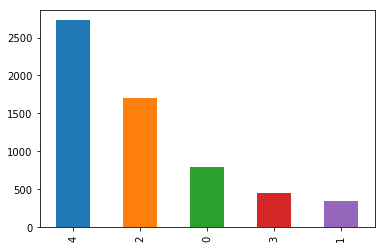

In [5]:
train_data.category.value_counts().plot(kind='bar')

# Housekeeping

In [31]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train_data["title"], train_data["category"], test_size = 0.2)
X_train = np.array(X_train)
X_test = np.array(X_valid)
Y_train = np.array(Y_train)
Y_test = np.array(Y_valid)

In [32]:
def train_model(classifier, feature_vector_train, label_train, feature_vector_valid, label_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label_train)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.accuracy_score(predictions, label_valid)

In [8]:
# le_hostname = preprocessing.LabelEncoder()
# le_hostname.fit_transform(train_data['hostname']).shape

# le_publisher = preprocessing.LabelEncoder()
# le_publisher.fit_transform(train_data['publisher'].fillna('UNKNOWN'))

# Word Embedding

In [7]:
from gensim.models import Doc2Vec
import gensim.models.doc2vec
from collections import OrderedDict
import multiprocessing
from sklearn import utils

In [57]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

In [8]:
cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"

In [65]:
def read_corpus(x, tokens_only=False):
    for record, tag in zip(x, list(range(len(x)))):
        if tokens_only:
            yield gensim.utils.simple_preprocess(record)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(record), [tag])

In [89]:
X_all = np.concatenate([X_train, X_valid])
all_corpus = list(read_corpus(X_all))

train_corpus = all_corpus[:len(X_train)]
valid_corpus = all_corpus[len(X_train):]

In [90]:
train_corpus[:2]

[TaggedDocument(words=['china', 'telecom', 'corporation', 'ltd', 'press', 'release', 'annual', 'results'], tags=[0]),
 TaggedDocument(words=['general', 'motors', 'recall', 'being', 'probed', 'by', 'doj'], tags=[1])]

In [91]:
# PV-DBOW plain
model_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample=0, 
        epochs=20, workers=cores)

# PV-DM w/ default averaging; a higher starting alpha may improve CBOW/PV-DM modes
model_dmm = Doc2Vec(dm=1, vector_size=100, window=10, negative=5, hs=0, min_count=2, sample=0, 
        epochs=20, workers=cores, alpha=0.05, comment='alpha=0.05')

# PV-DM w/ concatenation - big, slow, experimental mode
# window=5 (both sides) approximates paper's apparent 10-word total window size
model_dmc = Doc2Vec(dm=1, dm_concat=1, vector_size=100, window=5, negative=5, hs=0, min_count=2, sample=0, 
        epochs=20, workers=cores)

for model in [model_dbow, model_dmm, model_dmc]:
    model.build_vocab(all_corpus)
    
model_dbow_dmm = ConcatenatedDoc2Vec([model_dbow, model_dmm])
model_dbow_dmc = ConcatenatedDoc2Vec([model_dbow, model_dmc])

In [52]:
# model_dbow = gensim.models.doc2vec.Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample=0, 
#         epochs=20, workers=cores)
# model_dbow.build_vocab(train_corpus)
# model_dbow.train(train_corpus, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [44]:
# model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
# model_dbow.build_vocab(train_corpus)
# for epoch in range(40):
#     model_dbow.train(utils.shuffle([x for x in train_corpus]), total_examples=len(train_corpus), epochs=1)
#     model_dbow.alpha -= 0.002
#     model_dbow.min_alpha = model_dbow.alpha

In [92]:
def vec_for_learning(model, sents, reinfer=False):
    if reinfer:
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    else:
        targets, regressors = zip(*[(doc.tags[0], model.docvecs[doc.tags[0]]) for doc in sents])
    
    return targets, regressors

In [ ]:
reinfer=True

for model in [model_dbow, model_dmm, model_dmc, model_dbow_dmm, model_dbow_dmc]:
    _y_train, _X_train = vec_for_learning(model_dbow, train_corpus, reinfer=reinfer)
    _y_valid, _X_valid = vec_for_learning(model_dbow, valid_corpus, reinfer=reinfer)
    logreg = LogisticRegression()
    accuracy = train_model(logreg, _X_train, _y_train, _X_valid, _y_valid)
    print("LR: ", accuracy)

# Count Vectorizer

In [156]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=3500)
count_vect.fit(train_data["title"])

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(X_train)
xvalid_count =  count_vect.transform(X_test)

In [158]:
# Linear Classifier on Count Vectors
accuracy = train_model(LogisticRegression(), xtrain_count, Y_train, xvalid_count, Y_test)
print("LR, N-Gram Vectors: ", accuracy)

LR, N-Gram Vectors:  0.6409618573797679


In [159]:
# Naive Bayes Classifier on Count Vectors
accuracy = train_model(MultinomialNB(), xtrain_count, Y_train, xvalid_count, Y_test)
print("NB, N-Gram Vectors: ", accuracy)

NB, N-Gram Vectors:  0.6492537313432836


In [190]:
# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(max_depth=5, n_estimators=150), xtrain_count.tocsc(), Y_train, xvalid_count.tocsc(), Y_test)
print("Xgb, WordLevel TF-IDF: ", accuracy)

Xgb, WordLevel TF-IDF:  0.6442786069651741


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [236]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(SVC(), xtrain_count, Y_train, xvalid_count, Y_test)
print("SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  0.43283582089552236


In [237]:
# Random Forest on Ngram Level TF IDF Vectors
accuracy = train_model(RandomForestClassifier(n_estimators=180, criterion='entropy'), xtrain_count, Y_train, xvalid_count, Y_test)
print("RF, N-Gram Vectors: ", accuracy)

RF, N-Gram Vectors:  0.6650082918739635


In [25]:
print(fbeta_score(Y_test, Y_predict, average=None, beta=2))
print(fbeta_score(Y_test, Y_predict, average='macro', beta=2))
print(fbeta_score(Y_test, Y_predict, average='weighted', beta=2))

[0.60026385 0.3630363  0.59622196 0.39954338 0.75608037]
0.543029172262257
0.639202950714999


# TF-IDF

In [241]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), max_features=3000)
tfidf_vect_ngram.fit(train_data["title"])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [242]:
# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(LogisticRegression(), xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)
print("LR, N-Gram Vectors: ", accuracy)

LR, N-Gram Vectors:  0.6417910447761194


In [243]:
# Naive Bayes Classifier on Ngram Level TF IDF Vectors
accuracy = train_model(MultinomialNB(), xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)
print("NB, N-Gram Vectors: ", accuracy)

NB, N-Gram Vectors:  0.6500829187396352


In [194]:
# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=140), xtrain_tfidf_ngram.tocsc(), Y_train, xvalid_tfidf_ngram.tocsc(), Y_test)
print("Xgb, WordLevel TF-IDF: ", accuracy)

Xgb, WordLevel TF-IDF:  0.6517412935323383


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [216]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(SVC(), xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)
print("SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  0.43283582089552236


In [231]:
# Random Forest on Ngram Level TF IDF Vectors
accuracy = train_model(RandomForestClassifier(n_estimators=180, criterion='entropy'), xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)
print("RF, N-Gram Vectors: ", accuracy)

RF, N-Gram Vectors:  0.6650082918739635


# Create Submission Using Different Mothods

In [15]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), max_features=3500)
tfidf_vect_ngram.fit(train_data["title"])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3500, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [16]:
train_tfidf_ngram =  tfidf_vect_ngram.transform(train_data["title"])
test_tfidf_ngram =  tfidf_vect_ngram.transform(test_data["title"])

/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [152]:
# Naive Bayes Classifier on Ngram Level TF IDF Vectors
classifier =  MultinomialNB()
accuracy = train_model(classifier, train_tfidf_ngram, train_data["category"], train_tfidf_ngram, train_data["category"])
print("NB on training set ", accuracy)

NB on training set  0.704330512692882


In [11]:
classifier = xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=140)
accuracy = train_model(classifier, train_tfidf_ngram.tocsc(), train_data["category"], train_tfidf_ngram.tocsc(), train_data["category"])
print("XGB on training set ", accuracy)

XGB on training set  0.7355234776837565


/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [14]:
classifier = RandomForestClassifier(n_estimators=180, criterion='entropy')
accuracy = train_model(classifier, train_tfidf_ngram, train_data["category"], train_tfidf_ngram, train_data["category"])
print("RF on training set ", accuracy)

RF on training set  0.9928654388584702


In [12]:
# test_data["category"] = classifier.predict(test_tfidf_ngram.tocsc())
test_data["category"] = classifier.predict(test_tfidf_ngram)

/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [13]:
out=pd.DataFrame(test_data,columns=['article_id','category'])
out.to_csv('prediction.csv',index=False)